In [ ]:
%%time
#@title setup
import os, time, gc
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@gamma")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.shared.protein import _np_rmsd
from colabdesign.shared.parsers import aa2num
from copy import copy

from api import run_mmseqs2
import matplotlib.pyplot as plt
import string
import numpy as np
from sklearn.cluster import DBSCAN

def one_hot(x,cat=None):
  if cat is None: cat = np.max(x)+1
  oh = np.concatenate((np.eye(cat),np.zeros([1,cat])))
  return oh[x]

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb -P tmp/")
    return f"tmp/{pdb_code}.pdb"
  else:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb -P tmp/")
    return f"tmp/AF-{pdb_code}-F1-model_v4.pdb"

# if not os.path.exists('TMscore_cpp'):
#   os.system('wget https://zhanggroup.org/TM-score/TMscore_cpp.gz')
#   os.system('gunzip TMscore_cpp.gz')
#   os.system('chmod +x TMscore_cpp')

"""
Compute TM Scores between two PDBs and parse outputs
pdb_pred -- The path to the predicted PDB
pdb_native -- The path to the native PDB
test_len -- run asserts that the input and output should have the same length
"""
import subprocess

tm_re = re.compile(r'TM-score[\s]*=[\s]*(\d.\d+)')
ref_len_re = re.compile(r'Length=[\s]*(\d+)[\s]*\(by which all scores are normalized\)')
common_re = re.compile(r'Number of residues in common=[\s]*(\d+)')
super_re = re.compile(r'\(":" denotes the residue pairs of distance < 5\.0 Angstrom\)\\n([A-Z\-]+)\\n[" ", :]+\\n([A-Z\-]+)\\n')

def compute_tmscore(pdb_pred, pdb_native, test_len=False):
  cmd = (['./TMscore', pdb_pred, pdb_native])
  tmscore_output = str(subprocess.check_output(cmd))
  try:
    tm_out = float(tm_re.search(tmscore_output).group(1))
    reflen = int(ref_len_re.search(tmscore_output).group(1))
    common = int(common_re.search(tmscore_output).group(1))

    seq1 = super_re.search(tmscore_output).group(1)
    seq2 = super_re.search(tmscore_output).group(1)
  except Exception as e:
    print("Failed on: " + " ".join(cmd))
    raise e

  if test_len:
    assert reflen == common, cmd
    assert seq1 == seq2, cmd
    assert len(seq1) == reflen, cmd

  return tm_out

def sweep_dbscan(msa, deletion_matrix, verbose=True, min_eps=3, max_eps=20, eps_step=0.5,min_samples=5,keep_min=10):
  '''Input: MSA with shape N, L (N=num sequences, L=length) where chars are integers
  Ouptut: list of MSA clusters. each is shape [M,L] where M is variable, is the length of the new clustered MSA.
  Each cluster MSA has query sequence at start
  '''

  N, L = msa.shape
  ohe_msa = one_hot(msa).reshape(N,-1)
  eps_test_vals=np.arange(min_eps, max_eps+eps_step, eps_step)
  smaller_split = np.random.choice(range(len(msa)), int(len(msa)/4))
  test_split = ohe_msa[smaller_split]
  n_clusters=[]
  if verbose:
    print('eps\tnum clusters\tn not clustered')
  for eps in eps_test_vals:
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(test_split)
    n_clust = len(set(clustering.labels_))
    n_not_clustered = len(clustering.labels_[np.where(clustering.labels_==-1)])
    if verbose:
       print('%.2f\t%d\t%d' % (eps, n_clust, n_not_clustered))
    n_clusters.append(n_clust)
    if eps>10 and n_clust==1:
        break

  eps_max = eps_test_vals[np.argmax(n_clusters)]
  if verbose: print("eps max:", eps_max)
  clustering = DBSCAN(eps=eps_max, min_samples=min_samples).fit(ohe_msa)
  clusters = [x for x in list(set(clustering.labels_)) if x>=0]
  n_not_clustered = len(clustering.labels_[np.where(clustering.labels_==-1)])
  if verbose:
    print('%d clusters' % len(clusters))
    print('%d seqs not clustered' % n_not_clustered)

  clustered_msas=[]
  clustered_dtxs=[]
  query_seq=msa[0]
  query_dtx = deletion_matrix[0]

  for c in clusters:
    if len(np.where(clustering.labels_==c)[0])>=keep_min:
      cluster_msa = msa[np.where(clustering.labels_==c)]
      cluster_dtx = deletion_matrix[np.where(clustering.labels_==c)]

      cluster_msa = np.concatenate([[query_seq], cluster_msa])
      cluster_dtx = np.concatenate([[query_dtx], cluster_dtx])

      clustered_msas.append(cluster_msa)
      clustered_dtxs.append(cluster_dtx)

  return clustering.labels_, clustered_msas, clustered_dtxs

def make_msa_arr(msa, query_seq):
    # get dists between each member of msa and query seq
    dist_arr = [1-len(np.where(x- query_seq!=0)[0])/len(query_seq) for x in msa]

    sorted_msa = [msa[x] for x in np.argsort(dist_arr)]
    sorted_dist_arr = [dist_arr[x] for x in np.argsort(dist_arr)]

    plotting_arr = np.zeros([len(msa), len(query_seq)])*np.NaN

    ctr=0
    for dist, msa_seq in list(zip(sorted_dist_arr, sorted_msa)):
        for j, char in enumerate(msa_seq):
          if char!=21:
            plotting_arr[ctr,j] = dist
        ctr+=1

    return plotting_arr

def plot_cluster_msas(list_of_cluster_msas, pad_size=20, figsize=(8,8),dpi=100,sort_by_dist=False):
    query_seq=list_of_cluster_msas[0][0]
    arrs = [make_msa_arr(msa[1:], query_seq) for msa in list(reversed(list_of_cluster_msas))] # exclude 0 since that's the query seq
    mean_cluster_dists = [np.nanmean(x) for x in arrs]

    if sort_by_dist:
        arrs = [arrs[x] for x in np.argsort(mean_cluster_dists)]

    pad = np.zeros([pad_size, len(query_seq)])*np.NaN
    padded_arrs = [np.vstack([x, pad]) for x in arrs]

    plotting_arr = np.vstack(padded_arrs)

    yaxis_size,  xaxis_size= plotting_arr.shape

    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(
        plotting_arr,
    interpolation="nearest",
    aspect="auto",
    cmap="rainbow_r",
    vmin=0,
    vmax=1,
    origin="lower",
    extent=(0,xaxis_size, 0, yaxis_size),)

    for x in np.cumsum([len(x) for x in padded_arrs]):
        plt.axhline(x-0.5*pad_size,color='k',linewidth=0.5)

    plt.xlim(0, xaxis_size)
    plt.ylim(-0.5*pad_size, yaxis_size)
    plt.colorbar(label="Sequence identity to query",aspect=2, fraction=0.05)
    plt.xlabel("Positions")
    plt.ylabel("Sequences")

CPU times: user 98 µs, sys: 17 µs, total: 115 µs
Wall time: 119 µs


In [ ]:
predict.get_msa??

In [ ]:
get_pdb('2LHC')
get_pdb('2LHD')

'tmp/2LHD.pdb'

In [ ]:
seqs = {
'GAWT': 'MEAVDANSLAQAKEAAIKELKQYGIGDYYIKLINNAKTVEGVESLKNEILKALPTE',
'GA77':	'TTYKLILNLKQAKEEAIKELVDAGIAEKYIKLIANAKTVEGVWTLKDEILKATVTE',
'GA88':	'TTYKLILNLKQAKEEAIKELVDAGIAEKYIKLIANAKTVEGVWTLKDEILTFTVTE',
'GA91':	'TTYKLILNLKQAKEEAIKELVDAGTAEKYIKLIANAKTVEGVWTLKDEILTFTVTE',
'GA95':	'TTYKLILNLKQAKEEAIKELVDAGTAEKYIKLIANAKTVEGVWTLKDEIKTFTVTE',
'GA98':	'TTYKLILNLKQAKEEAIKELVDAGTAEKYFKLIANAKTVEGVWTLKDEIKTFTVTE',
'GB98':	'TTYKLILNLKQAKEEAIKELVDAGTAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE',
'GB98_T25I':'TTYKLILNLKQAKEEAIKELVDAGIAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE',
'GB98_T25I_L20A':'TTYKLILNLKQAKEEAIKEAVDAGIAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE',
'GB95':	'TTYKLILNLKQAKEEAIKEAVDAGTAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE',
'GB91':	'TTYKLILNLKQAKEEAIKEAVDAGTAEKYFKLYANAKTVEGVWTYKDEIKTFTVTE', # error in Fig. 2 PNAS 2009
'GB88':	'TTYKLILNLKQAKEEAITEAVDAGTAEKYFKLYANAKTVEGVWTYKDEIKTFTVTE',
'GB77':	'TTYKLILNGKQLKEEAITEAVDAATAEKYFKLYANAKTVEGVWTYKDETKTFTVTE',
'GBWT': 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE',}

u_lengths=[56]

msas, dtxs = {},{}
clustered_msas, clustered_dtxs = {},{}

for name, seq in seqs.items():
    msa, dtx = predict.get_msa(seq, name, max_msa=4096,
        do_not_filter=True,
        mmseqs2_fn=run_mmseqs2,
        hhfilter_fn=run_hhfilter)
    print(name, msa.shape)
    msas[name] = msa
    dtxs[name] = dtx

    cluster_labels, clustered_msa, clustered_dtx = sweep_dbscan(msa, dtx, verbose=True,
                                              min_samples=3, keep_min=10)
    print(len(clustered_msa))
    clustered_msas[name] = clustered_msa
    clustered_dtxs[name] = clustered_dtx

getting unpaired MSA
parsing msas
GAWT (358, 56)
eps	num clusters	n not clustered
3.00	8	43
3.50	10	33
4.00	7	29
4.50	7	29
5.00	8	22
5.50	7	18
6.00	7	10
6.50	2	5
7.00	2	1
7.50	1	0
8.00	1	0
8.50	1	0
9.00	1	0
9.50	1	0
10.00	1	0
10.50	1	0
eps max: 3.5
25 clusters
87 seqs not clustered
8
getting unpaired MSA
parsing msas
GA77 (435, 56)
eps	num clusters	n not clustered
3.00	12	35
3.50	10	31
4.00	8	29
4.50	10	20
5.00	9	18
5.50	8	9
6.00	5	3
6.50	4	3
7.00	3	2
7.50	1	0
8.00	1	0
8.50	1	0
9.00	1	0
9.50	1	0
10.00	1	0
10.50	1	0
eps max: 3.0
32 clusters
84 seqs not clustered
7
getting unpaired MSA
parsing msas
GA88 (461, 56)
eps	num clusters	n not clustered
3.00	11	48
3.50	10	38
4.00	10	33
4.50	8	31
5.00	8	17
5.50	3	11
6.00	3	3
6.50	3	1
7.00	2	0
7.50	2	0
8.00	2	0
8.50	1	0
9.00	1	0
9.50	1	0
10.00	1	0
10.50	1	0
eps max: 3.0
36 clusters
81 seqs not clustered
7
getting unpaired MSA
parsing msas
GA91 (432, 56)
eps	num clusters	n not clustered
3.00	10	49
3.50	7	48
4.00	7	35
4.50	7	30
5.00	5	16
5.50	4	10
6

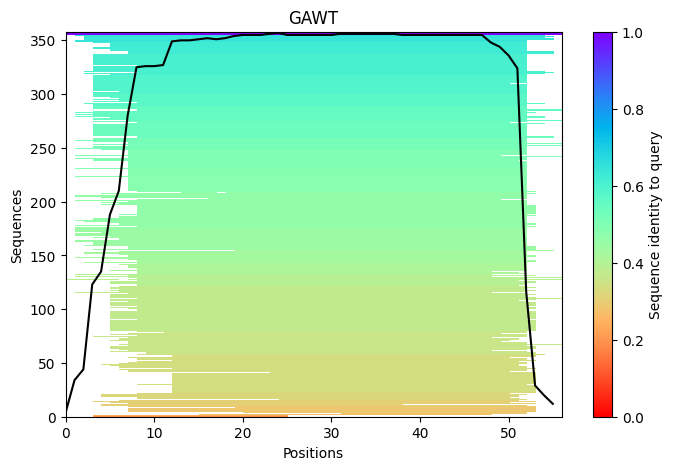

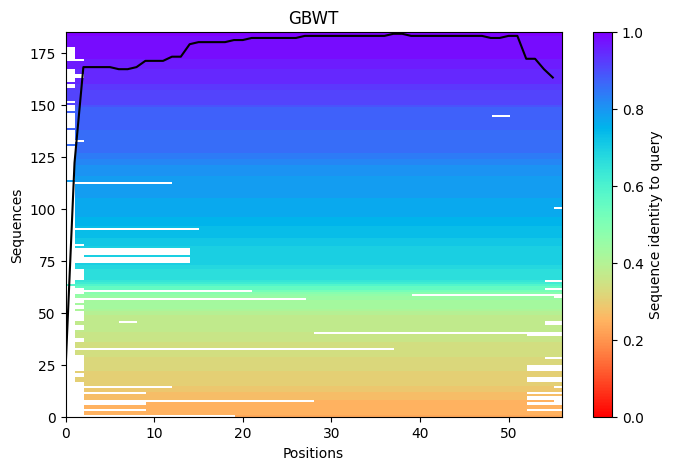

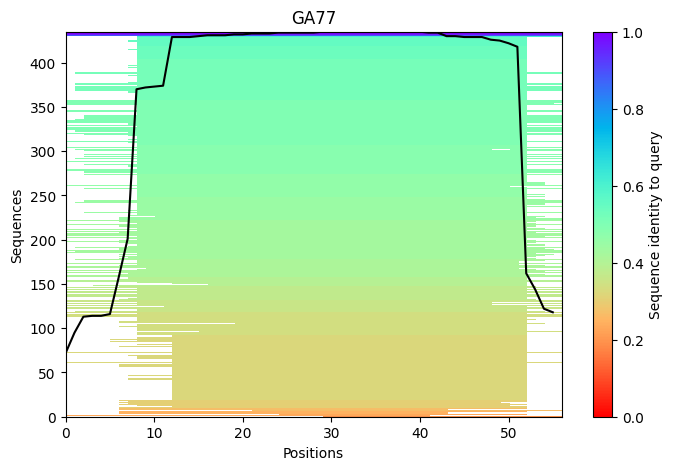

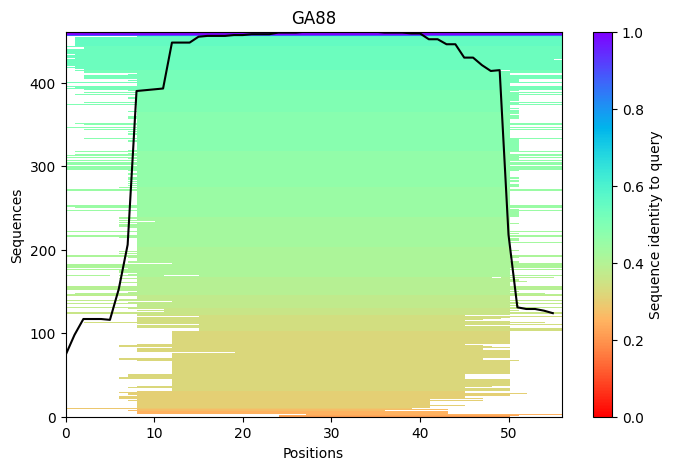

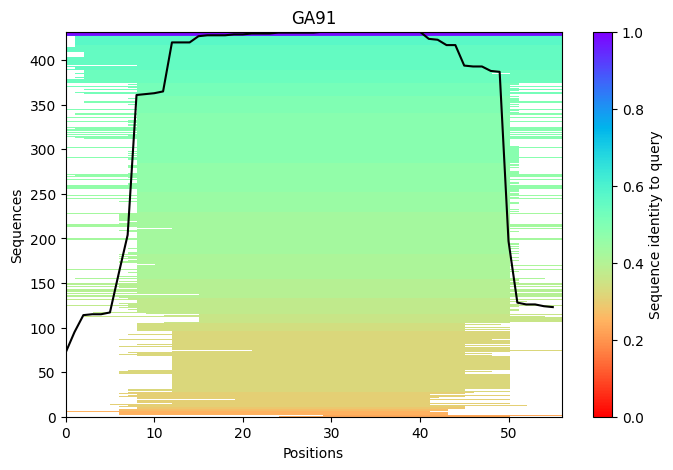

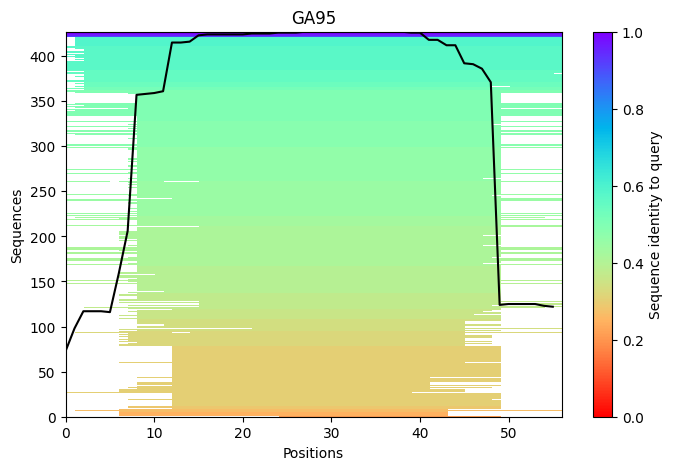

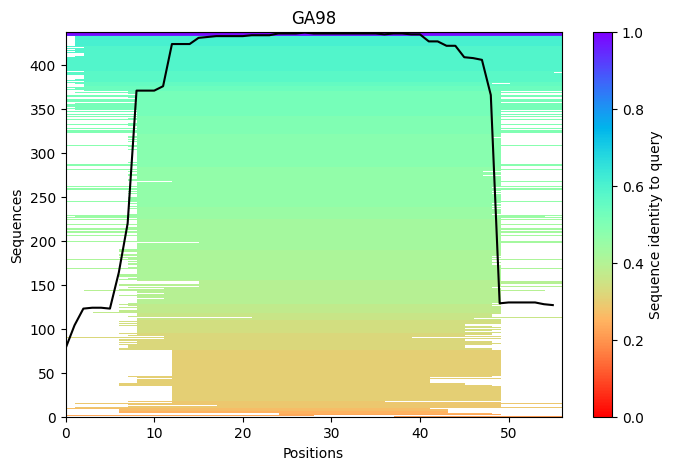

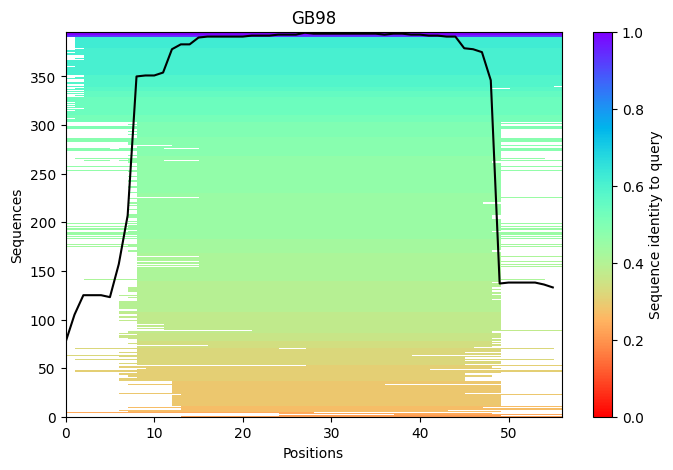

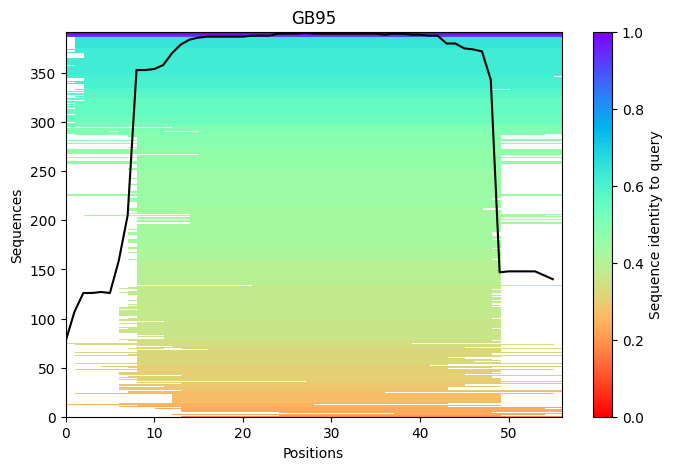

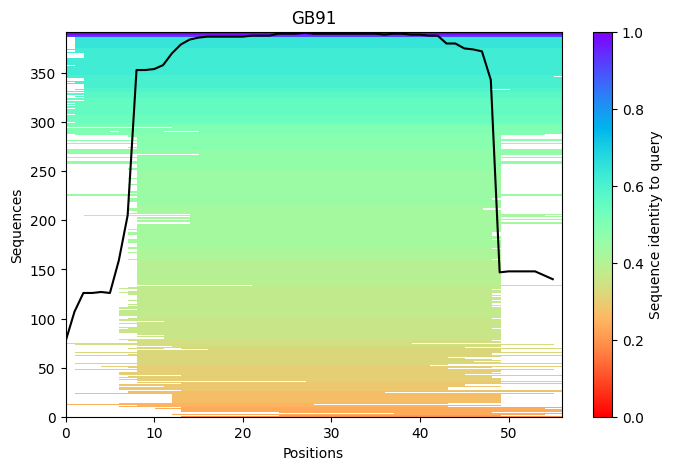

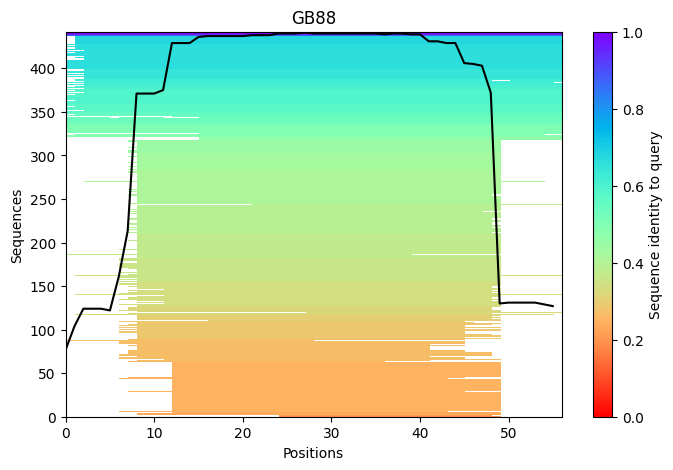

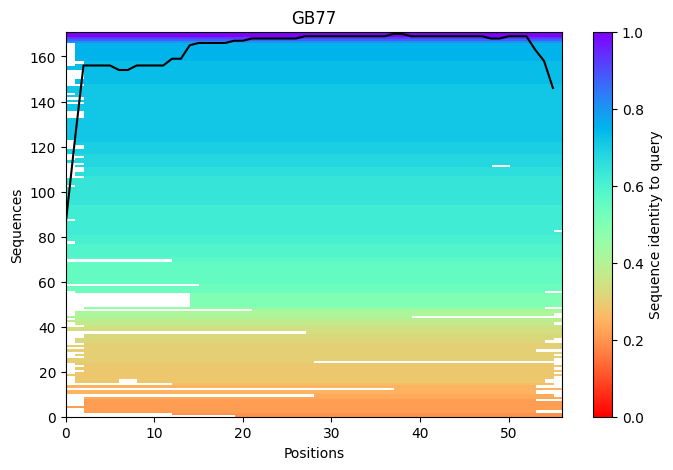

In [ ]:
for name, msa in msas.items():
  predict.plot_msa(msa,u_lengths)
  plt.title(name)

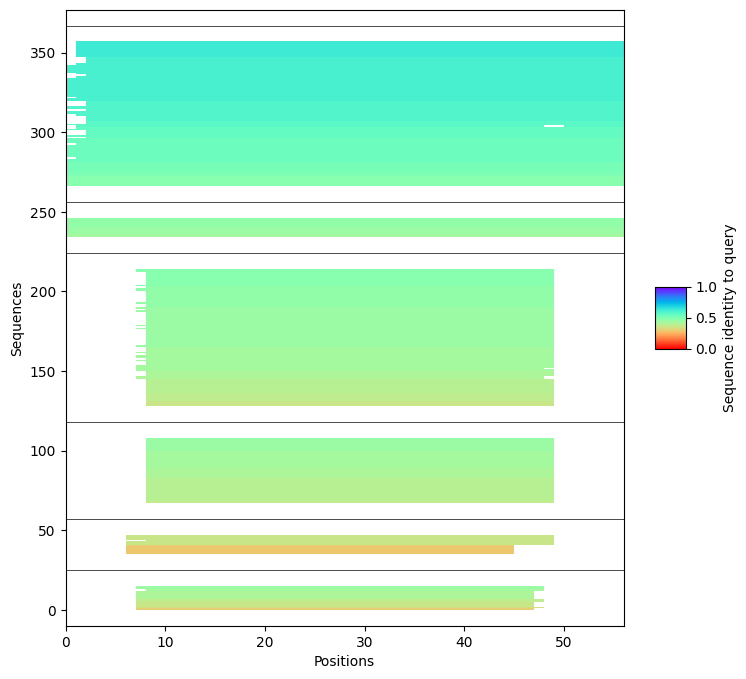

In [ ]:
plot_cluster_msas(clustered_msas['GB98_T25I_L20A'])

In [ ]:
jobname = "output" #@param {type:"string"}
model_type = "auto" #@param ["monomer (ptm)", "multimer (v3)", "auto"]
model = "all" #@param ["1", "2", "3", "4", "5", "all"]
num_recycles = 0 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
recycle_early_stop_tolerance = 0.0 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
use_initial_guess = False
#@markdown MSA options
num_msa = 512 #@param ["1","2","4","8","16","32", "64", "128", "256", "512"] {type:"raw"}
num_extra_msa = 1 #@param ["1","2","4","8","16","32", "64", "128", "256", "512", "1024","2048","4096"] {type:"raw"}
use_cluster_profile = False #@param {type:"boolean"}
use_mlm = False #@param {type:"boolean"}
#@markdown Stochastic options
use_dropout = False #@param {type:"boolean"}
seed = 0 #@param {type:"raw"}
num_seeds = 8 #@param ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}
batches = [None]
copies=1
use_templates=False

if model_type == "monomer (ptm)":
  use_multimer = False
elif model_type == "multimer (v3)":
  use_multimer = True
elif len(u_lengths) > 1 or copies > 1:
  use_multimer = True
else:
  use_multimer = False

model_opts = {"num_msa":num_msa, # number of sequences to use
              "num_extra_msa":num_extra_msa,
              "num_templates":len(batches),
              "use_mlm":True,
              "use_cluster_profile":use_cluster_profile,
              "use_multimer":use_multimer,
              "use_templates":use_templates,
              "use_batch_as_template":False,
              "use_dgram":True,
              "protocol":"hallucination",
              "best_metric":"pae",
              "optimize_seq":False,
              "debug":False,
              "clear_prev":False}

if "af" in dir():
  if model_opts != model_opts_:
    if model_opts["use_multimer"] == af._args["use_multimer"] \
    or model_opts["use_templates"] == af._args["use_templates"]:
      old_params = dict(zip(af._model_names,
                            af._model_params))
    else:
      print("loading alphafold params")
      old_params = {}
    af = mk_af_model(old_params=old_params,
                     **model_opts)
    model_opts_ = predict.copy_dict(model_opts)
else:
  print("loading alphafold params")
  af = mk_af_model(**model_opts)
  model_opts_ = predict.copy_dict(model_opts)

run_opts = {"seed":seed,
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess}

af.prep_inputs(u_lengths, copies=copies, seed=seed)

if use_templates:
  af.set_opt(use_initial_guess=use_initial_guess)
  for n,batch in enumerate(batches):
    af.set_template(batch=batch, n=n)
  af.set_opt("template",
             rm_sc=rm_sidechain,
             rm_seq=rm_sequence,
             rm_ic=rm_interchain)
af.set_opt("mlm",
           replace_fraction=0.15 if use_mlm else 0.0)

if model == "all":
  models = af._model_names
else:
  models = [af._model_names[int(model) - 1]]

pdb_path = f"{jobname}/pdb"
os.makedirs(pdb_path, exist_ok=True)

seeds = list(range(seed,seed+num_seeds))
print("running prediction")

outputs=[]

for name, seq in seqs.items():
  msa_list = [msas['GAWT'],msas['GBWT'], msas[name], *clustered_msas[name]]
  dtx_list = [dtxs['GAWT'], dtxs['GBWT'], dtxs[name],*clustered_dtxs[name]]
  msa_names = ['GA','GB','self']+['AFC_%d'%i for i in range(len(clustered_msas[name]))]
  msa_types = [x.split('_')[0] for x in msa_names]

  for i in range(len(msa_list)):
    if 'AFC' in msa_types[i] and '9' in name:
      seeds=[0, 1, 2, 3, 4, 5, 6, 7]
    else:
      seeds=[0]

    local_msa = copy(msa_list[i])
    local_msa[0] = aa2num(seq)

    af.set_msa(local_msa, dtx)

    for seed in seeds:
      af.set_seed(seed)
      for model in models:
        o={}
        recycle = 0
        af._inputs.pop("prev",None)
        stop_recycle = False
        while recycle < num_recycles + 1:
          af.predict(dropout=use_dropout, models=[model], verbose=False)

          print_str = f"MSA={msa_names[i]} {name} seed={seed} model={model} recycle={recycle}"
          print_key = ["plddt","ptm"]
          if len(af._lengths) > 1: print_key.append("i_ptm")
          for k in print_key:
            print_str += f" {k}={af.aux['log'][k]:.3f}"

          af._inputs["prev"] = af.aux["prev"]
          af._save_results(save_best=True, verbose=False)
          af._k += 1

          output_pdb = f"{pdb_path}/{msa_names[i]}_{name}_{model}_seed{seed}.pdb"
          af.save_current_pdb(output_pdb)

          recycle += 1
          if recycle > 1:
            rmsd_tol = _np_rmsd(af._tmp["traj"]["xyz"][-2],
                                af._tmp["traj"]["xyz"][-1],
                                use_jax=False)
            if rmsd_tol < recycle_early_stop_tolerance:
              stop_recycle = True
            print_str += f" rmsd_tol={rmsd_tol:.3f}"
          print(print_str)
          if stop_recycle: break

        for k in print_key:
          o.update({k: af.aux['log'][k]})

        o.update({'pdb_path': output_pdb})
        o.update({'model': model})
        o.update({'MSA': msa_types[i]})
        o.update({'name': name})
        outputs.append(o)

import pandas as pd
outputs = pd.DataFrame.from_records(outputs)
################
print("GC",gc.collect())

running prediction
MSA=GA GAWT seed=0 model=model_1_ptm recycle=0 plddt=0.840 ptm=0.596
MSA=GA GAWT seed=0 model=model_2_ptm recycle=0 plddt=0.854 ptm=0.643
MSA=GA GAWT seed=0 model=model_3_ptm recycle=0 plddt=0.852 ptm=0.597
MSA=GA GAWT seed=0 model=model_4_ptm recycle=0 plddt=0.862 ptm=0.640
MSA=GA GAWT seed=0 model=model_5_ptm recycle=0 plddt=0.843 ptm=0.616
MSA=GB GAWT seed=0 model=model_1_ptm recycle=0 plddt=0.619 ptm=0.405
MSA=GB GAWT seed=0 model=model_2_ptm recycle=0 plddt=0.645 ptm=0.427
MSA=GB GAWT seed=0 model=model_3_ptm recycle=0 plddt=0.628 ptm=0.345
MSA=GB GAWT seed=0 model=model_4_ptm recycle=0 plddt=0.556 ptm=0.302
MSA=GB GAWT seed=0 model=model_5_ptm recycle=0 plddt=0.587 ptm=0.342
MSA=self GAWT seed=0 model=model_1_ptm recycle=0 plddt=0.840 ptm=0.596
MSA=self GAWT seed=0 model=model_2_ptm recycle=0 plddt=0.854 ptm=0.643
MSA=self GAWT seed=0 model=model_3_ptm recycle=0 plddt=0.852 ptm=0.597
MSA=self GAWT seed=0 model=model_4_ptm recycle=0 plddt=0.862 ptm=0.640
MSA=sel

In [ ]:
import seaborn as sns
plt.rcParams['pdf.fonttype'] = 42

def compute_tmscore_(row, native_pdb):
  return compute_tmscore(row['pdb_path'],native_pdb)

outputs['TMscore_GA'] = outputs.apply(lambda row: compute_tmscore_(row, 'tmp/2LHC.pdb'), axis=1)
outputs['TMscore_GB'] = outputs.apply(lambda row: compute_tmscore_(row, 'tmp/2LHD.pdb'), axis=1)
outputs.to_csv('output.csv')

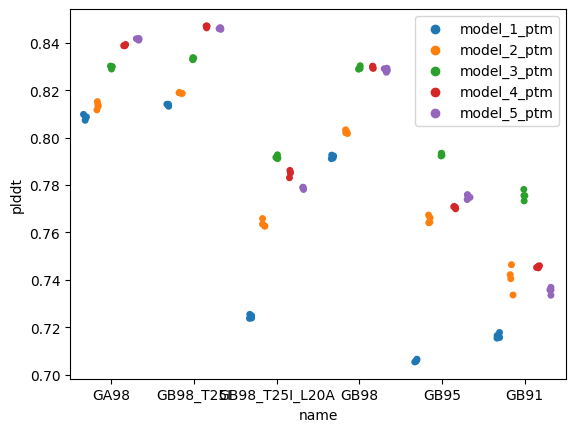

In [ ]:
order=['GA98', 'GB98_T25I','GB98_T25I_L20A', 'GB98', 'GB95', 'GB91', ]

sns.stripplot(x='name',hue='model',y='plddt',data=outputs.loc[outputs.MSA=='GA'],order=order,dodge=True)
plt.legend(bbox_to_anchor=(1,1))

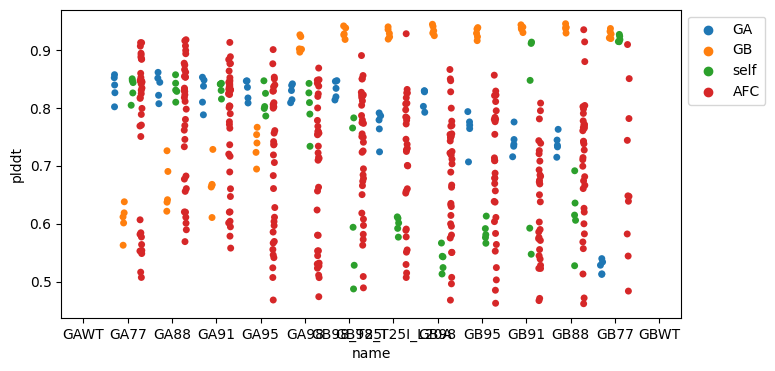

In [ ]:

order=['GAWT', 'GA77', 'GA88', 'GA91', 'GA95', 'GA98', 'GB98_T25I','GB98_T25I_L20A', 'GB98', 'GB95', 'GB91', 'GB88', 'GB77','GBWT']
#order=['GA95', 'GA98', 'GB98_T25I','GB98_T25I_L20A', 'GB98', 'GB95', 'GB91', ]
plt.figure(figsize=(8,4))
sns.stripplot(x='name',hue='MSA',y='plddt',data=outputs,order=order,dodge=True)
plt.legend(bbox_to_anchor=(1,1))
#plt.savefig('results.pdf',bbox_inches='tight')


<ipython-input-149-00a1dacd4bbe>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = outputs.loc[outputs.name==x][outputs.MSA=='self']
<ipython-input-149-00a1dacd4bbe>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = outputs.loc[outputs.name==x][outputs.MSA=='AFC']
<ipython-input-149-00a1dacd4bbe>:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = outputs.loc[outputs.name==x][outputs.MSA=='GA']
<ipython-input-149-00a1dacd4bbe>:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = outputs.loc[outputs.name==x][outputs.MSA=='GB']


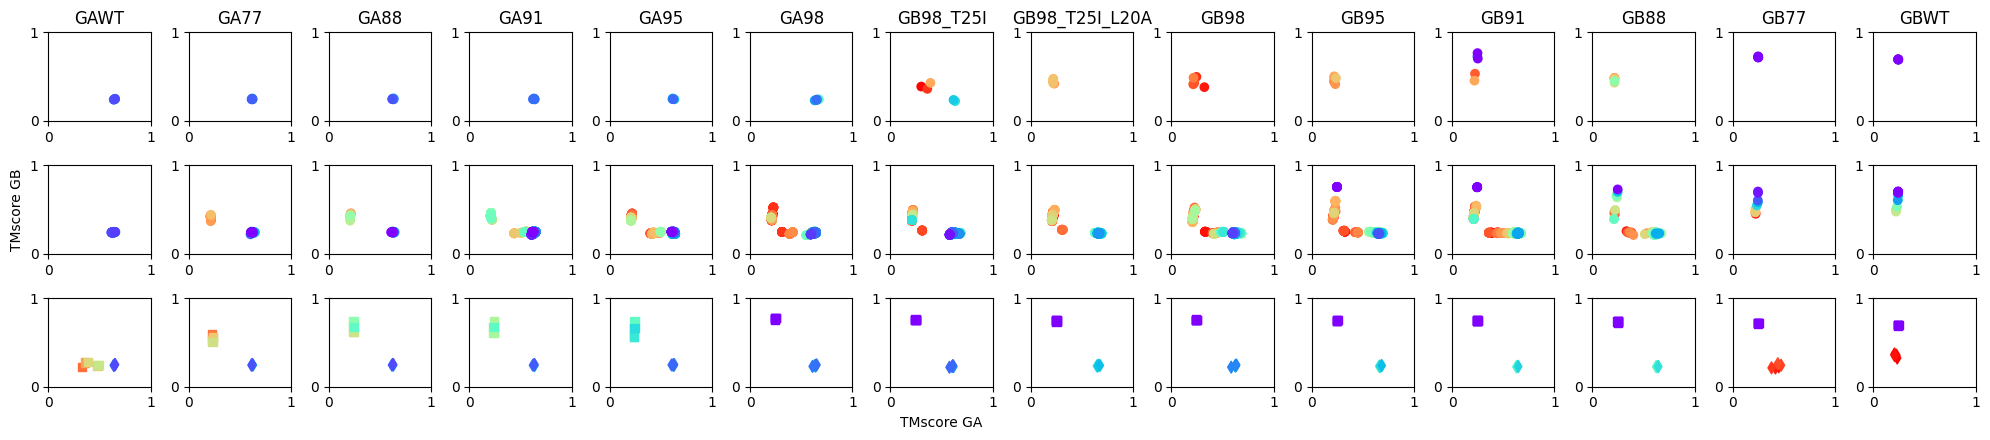

In [ ]:
plt.figure(figsize=(20,4.5))

order=['GAWT', 'GA77', 'GA88', 'GA91', 'GA95', 'GA98', 'GB98_T25I','GB98_T25I_L20A','GB98', 'GB95', 'GB91', 'GB88', 'GB77','GBWT']


for i,x in enumerate(order):
  plt.subplot(3,14,i+1)

  tmp = outputs.loc[outputs.name==x][outputs.MSA=='self']
  tmp = tmp.sort_values('plddt')

  plt.scatter(tmp['TMscore_GA'],tmp['TMscore_GB'], c=tmp['plddt'],cmap='rainbow_r',vmin=0.5,vmax=0.9)
  plt.title(x)
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.xticks([0,1])
  plt.yticks([0,1])

  plt.subplot(3,14,i+1+14)

  tmp = outputs.loc[outputs.name==x][outputs.MSA=='AFC']
  tmp = tmp.sort_values('plddt')

  plt.scatter(tmp['TMscore_GA'],tmp['TMscore_GB'], c=tmp['plddt'],cmap='rainbow_r',vmin=0.5,vmax=0.9)
  if i==0: plt.ylabel('TMscore GB')
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.xticks([0,1])
  plt.yticks([0,1])

  plt.subplot(3,14,i+1+14+14)


  tmp = outputs.loc[outputs.name==x][outputs.MSA=='GA']
  tmp = tmp.sort_values('plddt')
  plt.scatter(tmp['TMscore_GA'],tmp['TMscore_GB'], c=tmp['plddt'],cmap='rainbow_r',vmin=0.5,vmax=0.9,marker='d')

  tmp = outputs.loc[outputs.name==x][outputs.MSA=='GB']
  tmp = tmp.sort_values('plddt')

  plt.scatter(tmp['TMscore_GA'],tmp['TMscore_GB'], c=tmp['plddt'],cmap='rainbow_r',vmin=0.5,vmax=0.9,marker='s')

  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.xticks([0,1])
  plt.yticks([0,1])
  if i==6: plt.xlabel('TMscore GA')

plt.tight_layout()
plt.savefig('afcluster_on_pt_muts_big_figure.pdf',bbox_inches='tight')

<ipython-input-139-ca76f42e97e0>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = outputs.loc[outputs.name==x][outputs.MSA=='GA']
<ipython-input-139-ca76f42e97e0>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = outputs.loc[outputs.name==x][outputs.MSA=='GB']


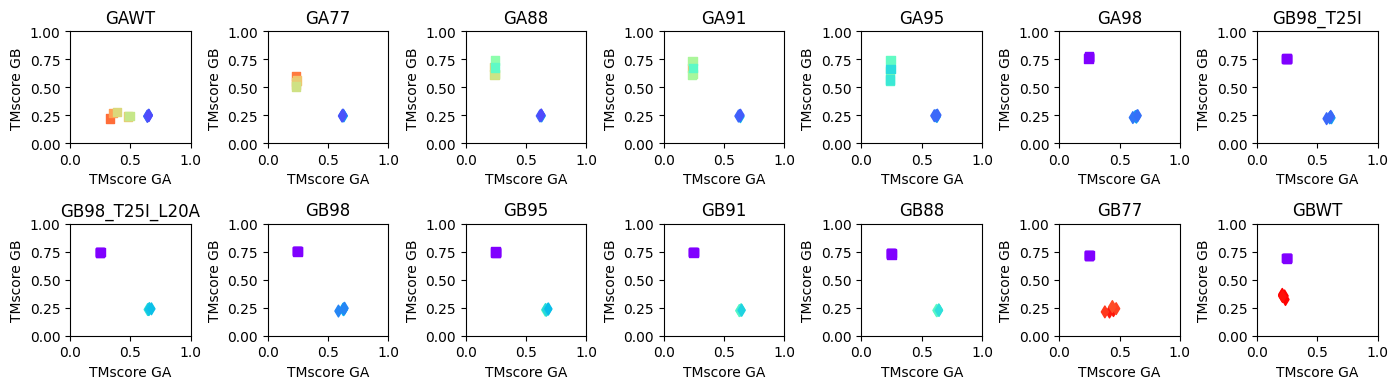

In [ ]:
plt.figure(figsize=(14,4))

order=['GAWT', 'GA77', 'GA88', 'GA91', 'GA95', 'GA98', 'GB98_T25I','GB98_T25I_L20A','GB98', 'GB95', 'GB91', 'GB88', 'GB77','GBWT']


for i,x in enumerate(order):
  plt.subplot(2,7,i+1)


  tmp = outputs.loc[outputs.name==x][outputs.MSA=='GA']
  tmp = tmp.sort_values('plddt')
  plt.scatter(tmp['TMscore_GA'],tmp['TMscore_GB'], c=tmp['plddt'],cmap='rainbow_r',vmin=0.5,vmax=0.9,marker='d')

  tmp = outputs.loc[outputs.name==x][outputs.MSA=='GB']
  tmp = tmp.sort_values('plddt')

  plt.scatter(tmp['TMscore_GA'],tmp['TMscore_GB'], c=tmp['plddt'],cmap='rainbow_r',vmin=0.5,vmax=0.9,marker='s')

  # tmp = outputs.loc[outputs.name==x][outputs.MSA=='self']
  # tmp = tmp.sort_values('plddt')

  # plt.scatter(tmp['TMscore_GA'],tmp['TMscore_GB'], c=tmp['plddt'],cmap='rainbow_r',vmin=0.5,vmax=0.9)

  plt.xlabel('TMscore GA')
  plt.ylabel('TMscore GB')
  plt.title(x)
  plt.xlim([0,1])
  plt.ylim([0,1])

plt.tight_layout()
plt.savefig('baselines_1.pdf',bbox_inches='tight')

<ipython-input-140-084f6411f86d>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = outputs.loc[outputs.name==x][outputs.MSA=='self']


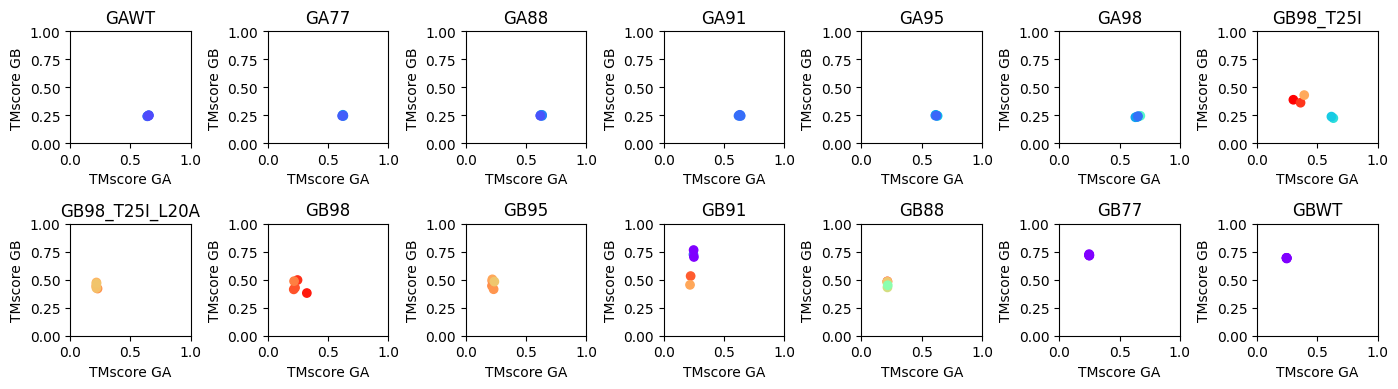

In [ ]:
plt.figure(figsize=(14,4))

order=['GAWT', 'GA77', 'GA88', 'GA91', 'GA95', 'GA98', 'GB98_T25I','GB98_T25I_L20A','GB98', 'GB95', 'GB91', 'GB88', 'GB77','GBWT']


for i,x in enumerate(order):
  plt.subplot(2,7,i+1)

  tmp = outputs.loc[outputs.name==x][outputs.MSA=='self']
  tmp = tmp.sort_values('plddt')

  plt.scatter(tmp['TMscore_GA'],tmp['TMscore_GB'], c=tmp['plddt'],cmap='rainbow_r',vmin=0.5,vmax=0.9)

  plt.xlabel('TMscore GA')
  plt.ylabel('TMscore GB')
  plt.title(x)
  plt.xlim([0,1])
  plt.ylim([0,1])

plt.tight_layout()
plt.savefig('baselines_full_msa.pdf',bbox_inches='tight')

In [ ]:
! zip results.zip output/pdb/*pdb